In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os

plt.style.use(['science', 'grid'])
plt.rc('figure', titlesize = 33, figsize = (21, 7), dpi = 210)
plt.rc('axes', titlesize = 27, labelsize = 21, titlepad = 21)
plt.rc('xtick', labelsize = 17)
plt.rc('ytick', labelsize = 17)

master = '/Users/fomo/Documents/Kaizen/code/physionet/data/CG Macros/preprocessed'

## segmenting glucose data

In [4]:
# defining segmenting function
def segmenter(data):
    segments = []
    
    data["timestamp"] = pd.to_datetime(data["timestamp"])
    data.sort_values(by="timestamp", inplace=True)

    # get the indices of the meals
    meal_indices = data.index[data["calories"].notna()].tolist()

    # iterate over all but the last meal index
    for meal, meal_index in enumerate(meal_indices[:-1]):
       
        end_idx = meal_indices[meal + 1] - 1
        meal_window = data.loc[meal_index:end_idx, ["timestamp", "libre_gl", "dexcom_gl", "hr"]]

        if "amount_consumed" in glucose_data.columns:
            amount_consumed = glucose_data.loc[meal_index, "amount_consumed"]
            if pd.isna(amount_consumed):
                amount_consumed = 100
        else:
            amount_consumed = 100
        
        
        segments.append({
                    "time": data.loc[meal_index, "timestamp"],
                    "macros": (amount_consumed/100)*data.loc[meal_index, ["calories", "carbs", "fat", "protein", "fiber"]],
                    "glucose_response": meal_window
                })
        
    return segments


In [5]:
import pickle
with open(os.path.join('/Users/fomo/Documents/Kaizen/code/physionet/data/CG Macros', 'subjects.pkl'), 'rb') as f:
    subjects = pickle.load(f)


preprocessed = [f for f in os.listdir(master) if f.endswith('.csv') and int(f.split('-')[1]) in subjects]
preprocessed = sorted(preprocessed, key=lambda x: int(x.split('-')[1]))

In [105]:
preprocessed

['CGMacros-001-preprocessed.csv',
 'CGMacros-002-preprocessed.csv',
 'CGMacros-003-preprocessed.csv',
 'CGMacros-004-preprocessed.csv',
 'CGMacros-005-preprocessed.csv',
 'CGMacros-006-preprocessed.csv',
 'CGMacros-007-preprocessed.csv',
 'CGMacros-008-preprocessed.csv',
 'CGMacros-009-preprocessed.csv',
 'CGMacros-010-preprocessed.csv',
 'CGMacros-011-preprocessed.csv',
 'CGMacros-012-preprocessed.csv',
 'CGMacros-013-preprocessed.csv',
 'CGMacros-014-preprocessed.csv',
 'CGMacros-015-preprocessed.csv',
 'CGMacros-016-preprocessed.csv',
 'CGMacros-017-preprocessed.csv',
 'CGMacros-018-preprocessed.csv',
 'CGMacros-019-preprocessed.csv',
 'CGMacros-020-preprocessed.csv',
 'CGMacros-021-preprocessed.csv',
 'CGMacros-022-preprocessed.csv',
 'CGMacros-023-preprocessed.csv',
 'CGMacros-027-preprocessed.csv',
 'CGMacros-029-preprocessed.csv',
 'CGMacros-030-preprocessed.csv',
 'CGMacros-031-preprocessed.csv',
 'CGMacros-032-preprocessed.csv',
 'CGMacros-033-preprocessed.csv',
 'CGMacros-034

In [107]:
test = pd.read_csv(os.path.join(master, preprocessed[0]))

segments = segmenter(test)

segment = segments[0]

df = segment["glucose_response"]

len(segments)

42

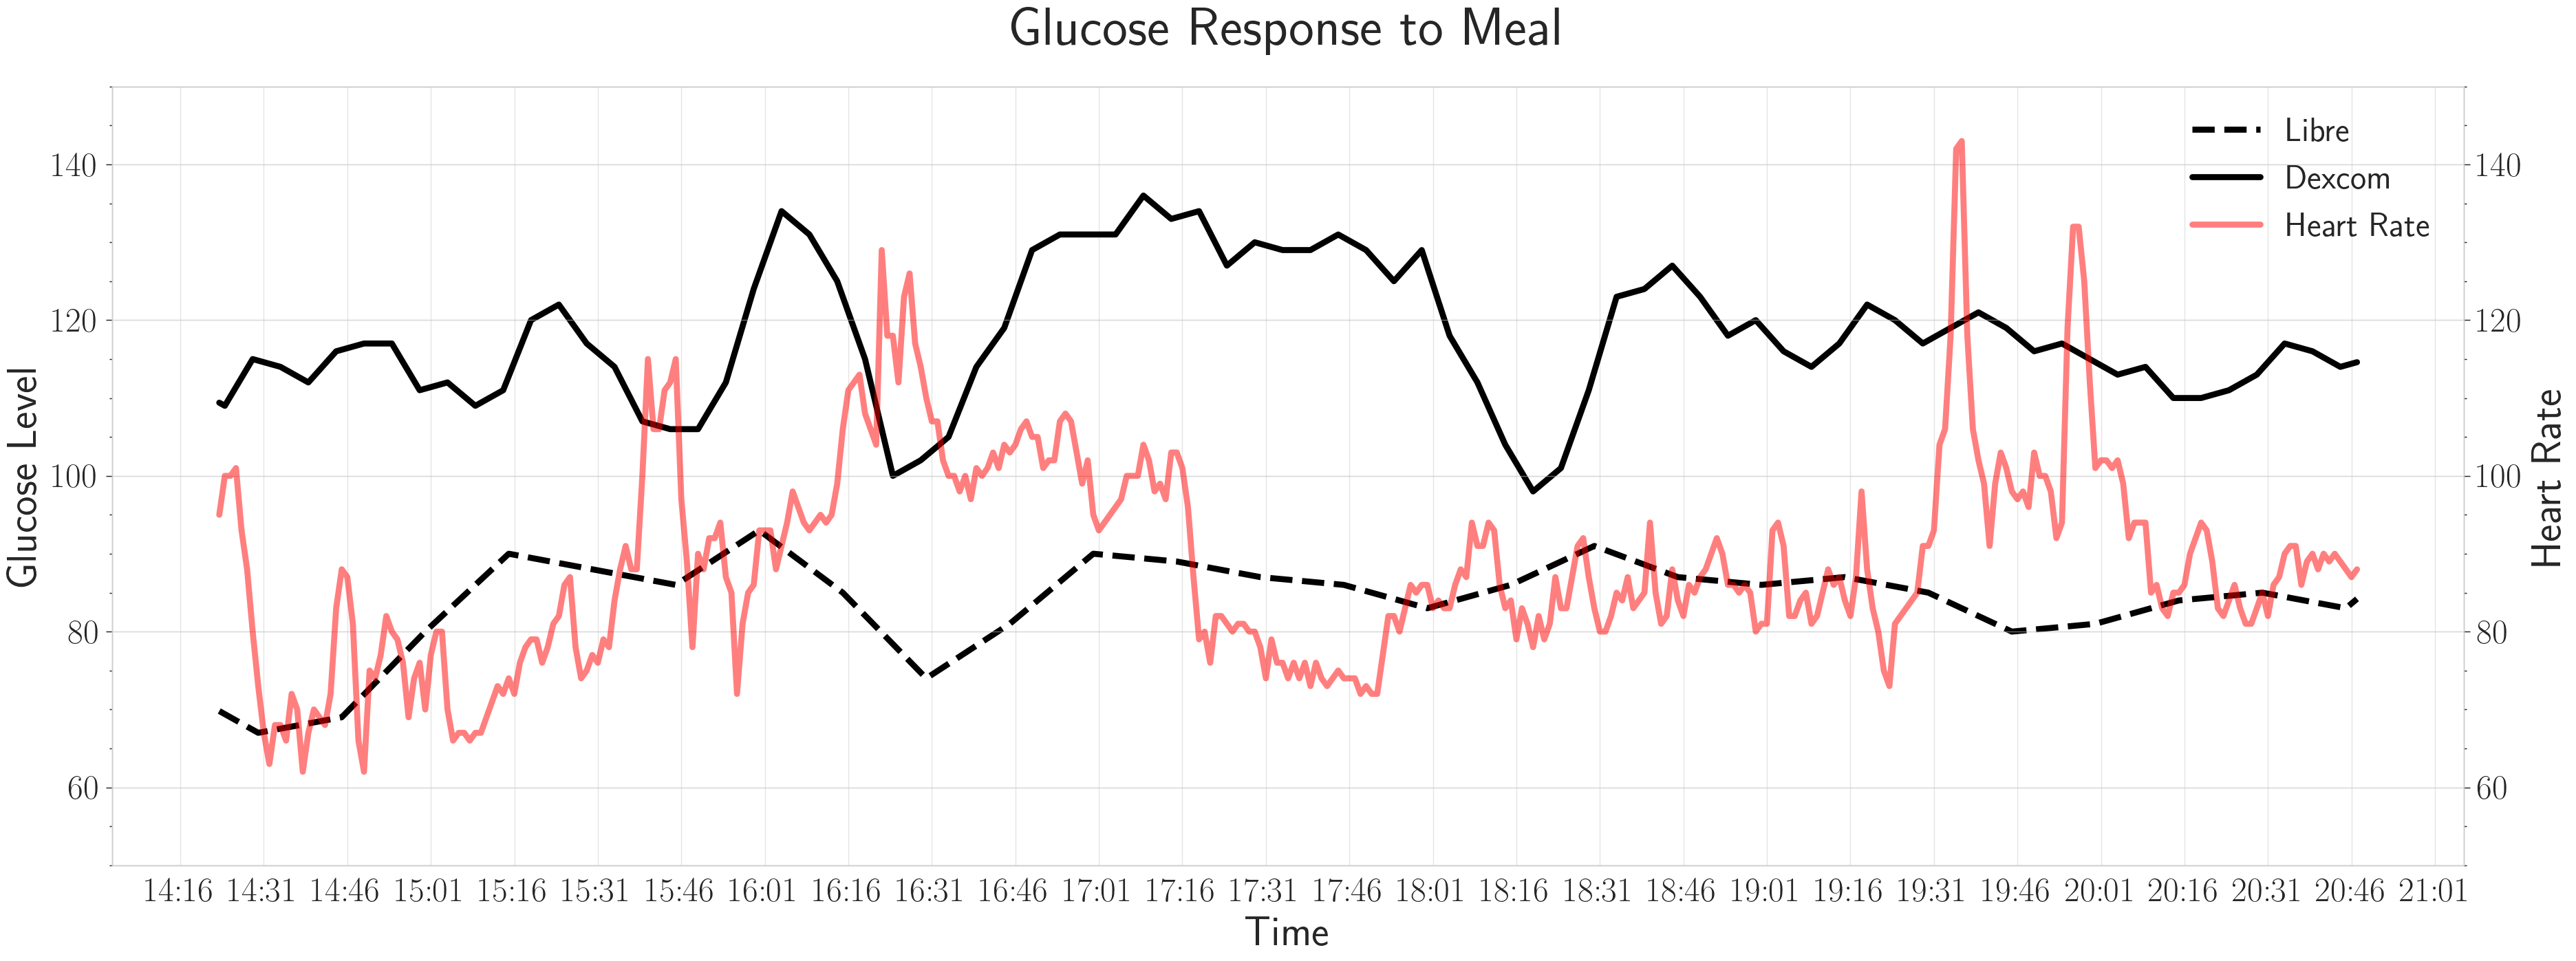

calories    1170.0
carbs         85.0
fat           54.2
protein       88.0
fiber         12.0
Name: 233, dtype: object


In [106]:
import matplotlib.dates as mdates

# create figure and axis
plt.rc("lines", linewidth = 3)
fig, ax = plt.subplots(figsize=(21, 7))

line1, = ax.plot(segment["glucose_response"]["timestamp"], segment["glucose_response"]["libre_gl"], label="Libre", color="black", linestyle="--")
line2, = ax.plot(segment["glucose_response"]["timestamp"], segment["glucose_response"]["dexcom_gl"], label="Dexcom", color="black", linestyle="-")

# set title and labels
ax.set_title("Glucose Response to Meal") 
ax.set_xlabel("Time")
ax.set_ylabel("Glucose Level")
ax.set_ylim(50, 150)

# format x-axis ticks (every 15 minutes)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))  # Set ticks every 15 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM

# format y-axis for heart rate
ax2 = ax.twinx()
line3, = ax2.plot(segment["glucose_response"]["timestamp"], segment["glucose_response"]["hr"], label="Heart Rate", color="red", alpha=0.5)
ax2.set_ylabel("Heart Rate")
ax2.set_ylim(50, 150)

lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper right', fontsize=17, frameon=False)

plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

# Print meal macros
print(segment["macros"])


In [ ]:
# max glucose level vs fiber and carbs

In [7]:
csvs = '/Users/fomo/Documents/Kaizen/code/physionet/data/CG Macros/'

microbes = pd.read_csv(os.path.join(csvs, 'microbes_edit.csv'))
microbes = microbes[microbes["subject"].isin(subjects)]
bio = pd.read_csv(os.path.join(csvs, 'bio_x_gut.csv'))
bio = bio[bio["subject"].isin(subjects)]

In [172]:
bio_columns = bio.columns

In [230]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# 1. Prepare the data.
X = microbes.astype(np.float32).values
y = bio["diabetes"].astype(np.float32)

# 2. Encode the target labels.
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 3. Scale the features.
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 4. Split data into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Create a custom Dataset.
class MicrobiomeClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()  # Use .float() for feature tensors.
        self.y = torch.from_numpy(y).long()   # Labels remain as long for CrossEntropyLoss.

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {'features': self.X[idx], 'label': self.y[idx]}

train_dataset = MicrobiomeClassificationDataset(X_train, y_train)
val_dataset   = MicrobiomeClassificationDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 6. Define the MLP classifier.
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
hidden_dim = 128  # You may need to adjust this based on your data.
output_dim = 3    # Three classes: diabetic, pre-diabetic, healthy

model = MLPClassifier(input_dim, hidden_dim, output_dim)

# 7. Set up loss and optimizer.
# CrossEntropyLoss expects raw logits and integer labels.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

# 8. Training loop.
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        inputs = batch['features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # outputs shape: [batch_size, 3]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_dataset)
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['features'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}, " +
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")



Epoch 1/50, Training Loss: 1.0904, Training Acc: 0.3030, Validation Loss: 1.1516, Validation Acc: 0.1111
Epoch 2/50, Training Loss: 1.0354, Training Acc: 0.3939, Validation Loss: 1.2224, Validation Acc: 0.1111
Epoch 3/50, Training Loss: 0.9730, Training Acc: 0.5455, Validation Loss: 1.2666, Validation Acc: 0.1111
Epoch 4/50, Training Loss: 0.9057, Training Acc: 0.6970, Validation Loss: 1.2653, Validation Acc: 0.3333
Epoch 5/50, Training Loss: 0.8685, Training Acc: 0.6970, Validation Loss: 1.2313, Validation Acc: 0.4444
Epoch 6/50, Training Loss: 0.8298, Training Acc: 0.6667, Validation Loss: 1.1920, Validation Acc: 0.4444
Epoch 7/50, Training Loss: 0.8094, Training Acc: 0.7273, Validation Loss: 1.1915, Validation Acc: 0.4444
Epoch 8/50, Training Loss: 0.7531, Training Acc: 0.7576, Validation Loss: 1.2416, Validation Acc: 0.4444
Epoch 9/50, Training Loss: 0.7158, Training Acc: 0.8788, Validation Loss: 1.3350, Validation Acc: 0.1111
Epoch 10/50, Training Loss: 0.6421, Training Acc: 0.787

In [8]:
records = []
glucose_responses = []

for subject in preprocessed:
    subject_number = int(subject.split('-')[1])

    # Filter subject-level data and extract the first row as a flat dictionary
    bio_data = bio[bio["subject"] == subject_number]
    microbe_data = microbes[microbes["subject"] == subject_number]
    bio_dict = bio_data.iloc[0].to_dict() if not bio_data.empty else {}
    microbe_dict = microbe_data.iloc[0].to_dict() if not microbe_data.empty else {}

    # Load the glucose data and segment into meals
    glucose_data = pd.read_csv(os.path.join(master, subject))
    meal_data = segmenter(glucose_data)

    id = 1
    for meal in meal_data:

        if len(meal["glucose_response"]) < 300:
            continue

        # Build the record for each meal (meal macros + biomarkers + microbiome)
        record = {"id": id, "subject": subject_number}
        record.update(meal["macros"])
        record.update(bio_dict)
        record.update(microbe_dict)
        records.append(record)

        # Compute the elementwise average for the first 300 samples for both sensors
        libre_samples = np.array(meal["glucose_response"]["libre_gl"])[:300]
        dexcom_samples = np.array(meal["glucose_response"]["dexcom_gl"])[:300]
        timeseries_average = (libre_samples + dexcom_samples) / 2
        glucose_responses.append(timeseries_average)
        
        max_glucose = max(timeseries_average)
        record["max_glucose"] = max_glucose
        
        
        id += 1

# Create final datasets:
# X is the DataFrame containing meal macros, biomarkers, and microbiome data.
X_temp = pd.DataFrame(records)

# y is a DataFrame where each row corresponds to a meal's 300-sample averaged glucose timeseries.
y_temp = pd.DataFrame(glucose_responses)


In [16]:
X_temp.dropna(inplace=True)

In [22]:
X_A_features = X_temp[["carbs", "fat", "fiber", "protein"]].astype(np.float32)
y_A_target = X_temp["microbiome-induced_stress"].astype(np.float32)

X_B_features = X_temp[["carbs", "fingerstick_avg", "a1c"]]
y_B_target = X_temp[["microbiome-induced_stress"]]

X_C_features = X_temp[["carbs", "fat", "fiber", "protein", "a1c", "ethnicity_african_american", "ethnicity_latino", "ethnicity_white"]]
y_C_target = X_temp["diabetes"]

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression #A
from sklearn.tree import DecisionTreeRegressor #B
from sklearn.linear_model import LogisticRegression #C
from sklearn.metrics import mean_squared_error, accuracy_score



scaler = StandardScaler()
X_A_features = scaler.fit_transform(X_A_features)
X_B_features = scaler.fit_transform(X_B_features)
X_C_features = scaler.fit_transform(X_C_features)

X_train, X_test, y_train, y_test = train_test_split(X_C_features, y_C_target, test_size=0.2, random_state=42)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(model.predict_proba(X_test).round(2))

print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")



[[1.   0.   0.  ]
 [0.   0.05 0.95]
 [1.   0.   0.  ]
 [0.92 0.08 0.  ]
 [0.   0.17 0.83]
 [0.   0.01 0.99]
 [0.01 0.82 0.17]
 [0.   0.01 0.99]
 [0.92 0.08 0.  ]
 [0.99 0.01 0.  ]
 [0.   0.17 0.83]
 [0.39 0.6  0.  ]
 [0.59 0.41 0.  ]
 [0.98 0.02 0.  ]
 [0.01 0.82 0.17]
 [0.02 0.91 0.07]
 [0.   0.   1.  ]
 [0.02 0.73 0.25]
 [0.   0.   1.  ]
 [0.   0.06 0.94]
 [0.   0.05 0.95]
 [0.92 0.08 0.  ]
 [0.61 0.39 0.  ]
 [0.02 0.89 0.09]
 [0.03 0.73 0.24]
 [0.92 0.08 0.  ]
 [0.17 0.75 0.07]
 [0.76 0.24 0.  ]
 [0.94 0.06 0.  ]
 [0.02 0.89 0.09]
 [0.34 0.66 0.  ]
 [0.   0.   1.  ]
 [0.41 0.58 0.  ]
 [0.21 0.78 0.01]
 [0.15 0.84 0.01]
 [0.89 0.11 0.  ]
 [0.   0.01 0.99]
 [0.   0.01 0.99]
 [0.17 0.75 0.08]
 [0.4  0.6  0.  ]
 [0.15 0.78 0.07]
 [0.   0.25 0.75]
 [0.15 0.84 0.01]
 [0.   0.71 0.29]
 [0.01 0.93 0.06]
 [0.   0.02 0.98]
 [0.   0.04 0.96]
 [0.   0.   1.  ]
 [0.98 0.02 0.  ]
 [0.57 0.43 0.  ]
 [0.89 0.11 0.  ]
 [0.98 0.02 0.  ]
 [0.58 0.42 0.  ]
 [0.88 0.12 0.  ]
 [0.   0.25 0.75]
 [0.99 0.0

In [24]:
X_temp.shape, y_temp.shape

X_predictor = X_temp.merge(y_temp, left_index=True, right_index=True)
X_predictor.dropna(inplace=True)

y_predictor = X_predictor[[i for i in range(300)]]
X_predictor.drop(columns = [i for i in range(300)], inplace=True)

X_predictor.shape, y_predictor.shape


((685, 2030), (685, 300))

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np

# Assume X and y have been created previously:
# - X is a DataFrame with shape (n_samples, n_features)
# - y is a DataFrame with shape (n_samples, 300), where each row is a timeseries

X = X_predictor.astype(np.float32)
y = y_predictor.astype(np.float32)

X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

# Convert X and y to torch tensors (ensuring they are of type float32)
if isinstance(X, pd.DataFrame):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
else:
    X_tensor = torch.tensor(X, dtype=torch.float32)

if isinstance(y, pd.DataFrame):
    y_tensor = torch.tensor(y.values, dtype=torch.float32)
else:
    y_tensor = torch.tensor(y, dtype=torch.float32)

# Create a dataset and data loader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the PyTorch model
class GlucosePredictor(nn.Module):
    def __init__(self, input_dim, output_dim=300):
        super(GlucosePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)  # Output layer with 300 units for the timeseries
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model
input_dim = X_tensor.shape[1]
model = GlucosePredictor(input_dim=input_dim, output_dim=300)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 50  # Adjust the number of epochs as needed
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/50, Loss: 15334.6792
Epoch 2/50, Loss: 4215.3934
Epoch 3/50, Loss: 1486.2688
Epoch 4/50, Loss: 1026.9446
Epoch 5/50, Loss: 920.3407
Epoch 6/50, Loss: 864.9476
Epoch 7/50, Loss: 815.8341
Epoch 8/50, Loss: 797.1980
Epoch 9/50, Loss: 742.8103
Epoch 10/50, Loss: 720.4995
Epoch 11/50, Loss: 690.5332
Epoch 12/50, Loss: 671.9301
Epoch 13/50, Loss: 669.1674
Epoch 14/50, Loss: 670.4502
Epoch 15/50, Loss: 629.7420
Epoch 16/50, Loss: 652.5347
Epoch 17/50, Loss: 632.4422
Epoch 18/50, Loss: 601.9171
Epoch 19/50, Loss: 608.8833
Epoch 20/50, Loss: 605.9198
Epoch 21/50, Loss: 591.0515
Epoch 22/50, Loss: 598.3430
Epoch 23/50, Loss: 603.4772
Epoch 24/50, Loss: 596.2563
Epoch 25/50, Loss: 596.9011
Epoch 26/50, Loss: 594.2828
Epoch 27/50, Loss: 588.4055
Epoch 28/50, Loss: 585.5354
Epoch 29/50, Loss: 590.4270
Epoch 30/50, Loss: 587.0542
Epoch 31/50, Loss: 587.6487
Epoch 32/50, Loss: 595.9776
Epoch 33/50, Loss: 581.5128
Epoch 34/50, Loss: 586.0373
Epoch 35/50, Loss: 584.9211
Epoch 36/50, Loss: 574.3

In [264]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Data Preprocessing
# -------------------------------

# Assume X_predictor and y_predictor are defined.
# X_predictor: DataFrame of shape (n_samples, n_features)
# y_predictor: DataFrame of shape (n_samples, 300)

# Convert to numpy arrays and ensure type float32
X = X_predictor.astype(np.float32)
y = y_predictor.astype(np.float32)

# Standard scaling for features and targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Convert to torch tensors
if isinstance(X_scaled, pd.DataFrame):
    X_tensor = torch.tensor(X_scaled.values, dtype=torch.float32)
else:
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

if isinstance(y_scaled, pd.DataFrame):
    y_tensor = torch.tensor(y_scaled.values, dtype=torch.float32)
else:
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Create dataset and train/validation split (80/20)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# Improved Model: Encoder-Decoder with LSTM
# -------------------------------

class GlucosePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, seq_length=300, dropout=0.2):
        super(GlucosePredictor, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Encoder: transforms static features into a context vector.
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Decoder: LSTM that produces the time series.
        self.decoder_lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        # Output layer applied to each time step.
        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size = x.size(0)
        # Encoder: get context vector from static input features.
        context = self.encoder(x)  # shape: (batch_size, hidden_dim)

        # Initialize LSTM hidden and cell states using the context.
        # h0 shape: (num_layers, batch_size, hidden_dim)
        h0 = context.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)

        # Decoder input: for simplicity, we use a tensor of zeros as the initial inputs.
        # This tensor has shape (batch_size, seq_length, 1)
        decoder_input = torch.zeros(batch_size, self.seq_length, 1, device=x.device)

        # Pass through LSTM decoder.
        lstm_out, _ = self.decoder_lstm(decoder_input, (h0, c0))
        # Apply final fully connected layer to each time step.
        outputs = self.fc_out(lstm_out).squeeze(-1)  # shape: (batch_size, seq_length)
        return outputs

# Instantiate the model
input_dim = X_tensor.shape[1]
model = GlucosePredictor(input_dim=input_dim, hidden_dim=64, num_layers=2, seq_length=300, dropout=0.2)

# -------------------------------
# Training Setup
# -------------------------------

# Use GPU if available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# -------------------------------
# Training Loop with Early Stopping
# -------------------------------

n_epochs = 100
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_loader.dataset)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping check: save the best model state.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

# Load the best model state and report
model.load_state_dict(best_model_state)
print("Training complete. Best validation loss: {:.4f}".format(best_val_loss))


/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100 | Train Loss: 1.0155 | Val Loss: 0.9500
Epoch 2/100 | Train Loss: 1.0110 | Val Loss: 0.9473
Epoch 3/100 | Train Loss: 1.0108 | Val Loss: 0.9439
Epoch 4/100 | Train Loss: 1.0024 | Val Loss: 0.9410
Epoch 5/100 | Train Loss: 0.8955 | Val Loss: 0.6932
Epoch 6/100 | Train Loss: 0.7509 | Val Loss: 0.8139
Epoch 7/100 | Train Loss: 0.8172 | Val Loss: 0.7688
Epoch 8/100 | Train Loss: 0.8246 | Val Loss: 0.7595
Epoch 9/100 | Train Loss: 0.7887 | Val Loss: 0.7246
Epoch 10/100 | Train Loss: 0.7592 | Val Loss: 0.6840
Epoch 11/100 | Train Loss: 0.7215 | Val Loss: 0.6417
Epoch 12/100 | Train Loss: 0.7060 | Val Loss: 0.6684
Epoch 13/100 | Train Loss: 0.6910 | Val Loss: 0.6295
Epoch 14/100 | Train Loss: 0.6925 | Val Loss: 0.6608
Epoch 15/100 | Train Loss: 0.6653 | Val Loss: 0.5610
Epoch 16/100 | Train Loss: 0.6852 | Val Loss: 0.6456
Epoch 17/100 | Train Loss: 0.6984 | Val Loss: 0.6437
Epoch 18/100 | Train Loss: 0.7195 | Val Loss: 0.6365
Epoch 19/100 | Train Loss: 0.7150 | Val Loss: 0.6371
Ep